In [10]:
#from google.colab import files
#uploaded = files.upload()

In [11]:
#pip install yfinance --upgrade --no-cache-dir
#!pip install getFamaFrenchFactors

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf # documentation: https://github.com/ranaroussi/yfinance
from sklearn.linear_model import LinearRegression
import datetime as dt
from math import sqrt
import os
from scipy import stats
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
import pandas_datareader
import matplotlib.colors as mcolors
import math
from dateutil.relativedelta import relativedelta

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14, 10]

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 30)

1. An example of a factorial model including exogenous and endogenous factors based on the APT approach proposed by Ross to estimate the multi-beta relationship for a global stock index and a sectoral sub-index; you can also introduce the two additional factors proposed by Fama and French (See AP-empirical application 2).

CAPM: $$\text{E}[R_i] = R_f + \beta_i(\text{E}[R_m]-R_f)$$

$$ \beta_i = \frac{\text{Cov}(R_i,R_m)}{\text{Var}(R_m)} $$

APT:
$$\forall j,\text{E}(R_j)-R_F = \sum^K_{k=1} \lambda_k \beta _{jk}$$

Global stock index: S&P 500
Sectoral sub-index: S&P 500 IT Services Industry Index

Start:

In [13]:
tickers = "^GSPC ^DJI"
index = "^GSPC"
subindex = "^DJI"
#^GSPC - S&P 500
#^DJI - Dow Jones Industrial Average


start = dt.datetime(2000,1,1)
end = dt.datetime(2022,12,31)
data = pd.DataFrame()

data = yf.download(tickers, start=(start - relativedelta(months = 6)), end=end, interval='1mo')
data = pd.DataFrame(data['Adj Close']).reset_index(level=0)

data.rename(columns = {index:'index',subindex:'subindex',}, inplace = True)

[*********************100%%**********************]  2 of 2 completed


In [14]:
fff = pd.read_csv('/content/fama_french_clean.csv')
fff['Date'] = pd.to_datetime(fff['Date'], dayfirst=True)

In [29]:
gdp = pd.read_csv('/content/GDPC1.csv')
unemp = pd.read_csv('/content/UNRATE.csv')
exp = pd.read_csv('/content/EXPGSC1.csv')
ppi = pd.read_csv('/content/PPIACO.csv')


In [31]:
from tsdisagg import #for interpolating missing GDP data [Denton-Cholette] flow - sum, stock - last

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.2/347.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tsdisagg: filename=tsdisagg-1.0.2-py3-none-any.whl size=10240 sha256=ece1c9ecc16290dda1fe6b9e61ffc5e91609334566528fa5a36c8809893e07e0
  Stored in directory: /root/.cache/pip/wheels/3e/5c/4c/f7126e83ddad72c777fe1ea9a6ac7b87508845a9c0cbacb947
Successfully built tsdisagg


In [16]:
macro = pd.merge(gdp,unemp,on='DATE',how='outer')
macro = pd.merge(macro,exp,on='DATE',how='outer')
macro = pd.merge(macro,ppi,on='DATE',how='outer')
macro.rename(columns = {'DATE':'Date','GDPC1':'gdp','UNRATE':'unemp','EXPGSC1':'exp','PPIACO':'ppi'}, inplace = True)
macro['Date'] = pd.to_datetime(macro['Date'])
macro['gdp'] = pd.to_numeric(macro['gdp'])

In [17]:
#merge data together
data = pd.merge(data,fff,on='Date',how='outer')
data = pd.merge(data,macro,on='Date',how='outer')

data = data.set_index('Date')

In [18]:
data = data.interpolate(method='cubic')

In [19]:
data['gdp'] = 100*(data['gdp']-data['gdp'].shift(1))/data['gdp'].shift(1)
data['exp'] = 100*(data['exp']-data['exp'].shift(1))/data['exp'].shift(1)
data['ppi'] = 100*(data['ppi']-data['ppi'].shift(1))/data['ppi'].shift(1)
data['unemp'] = 100*(data['unemp']-data['unemp'].shift(1))/data['unemp'].shift(1)

data['index_ret'] = 100*(data['index']-data['index'].shift(1))/data['index'].shift(1)
data['subindex_ret'] = 100*(data['subindex']-data['subindex'].shift(1))/data['subindex'].shift(1)


#Extract error from AR model

In [20]:
data = data.loc[(data.index >= start) & (data.index <= end)]

In [21]:
data

,subindex,index,Mkt-RF,SMB,HML,RF,gdp,unemp,exp,ppi,index_ret,subindex_ret
Date,,,,,,,,,,,,
2000-01-01,10940.530273,1394.459961,-4.74,5.77,-1.88,0.41,0.217471,0.000000,0.593080,0.391236,-5.090355,-4.841124
2000-02-01,10128.309570,1366.420044,2.45,21.36,-9.59,0.43,0.581883,2.500000,0.870966,1.169135,-2.010808,-7.423961
2000-03-01,10921.919922,1498.579956,5.20,-17.20,8.13,0.47,0.674382,-2.439024,0.998324,0.770416,9.671983,7.835566
2000-04-01,10733.910156,1452.430054,-6.40,-6.68,7.26,0.46,0.554116,-5.000000,1.148314,-0.076453,-3.079576,-1.721398
2000-05-01,10522.330078,1420.599976,-4.42,-6.05,4.75,0.50,0.168459,5.263158,1.067818,0.688600,-2.191505,-1.971137
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,31510.429688,3955.000000,-3.77,1.40,0.29,0.19,0.230770,5.714286,-0.126416,-1.001932,-4.244013,-4.063614
2022-09-01,28725.509766,3585.620117,-9.35,-0.81,0.05,0.19,0.209736,-5.405405,-0.526099,-0.611398,-9.339567,-8.838089
2022-10-01,32732.949219,3871.979980,7.83,0.06,8.01,0.23,0.193578,5.714286,-0.233280,-1.058985,7.986341,13.950804


In [22]:
#check for missing variables:
print('The number of missing values is: ',data.isnull().sum())

The number of missing values is:  subindex        0
index           0
Mkt-RF          0
SMB             0
HML             0
RF              0
gdp             0
unemp           0
exp             0
ppi             0
index_ret       0
subindex_ret    0
dtype: int64


Text(0.5, 1.0, 'Logarithmic price')

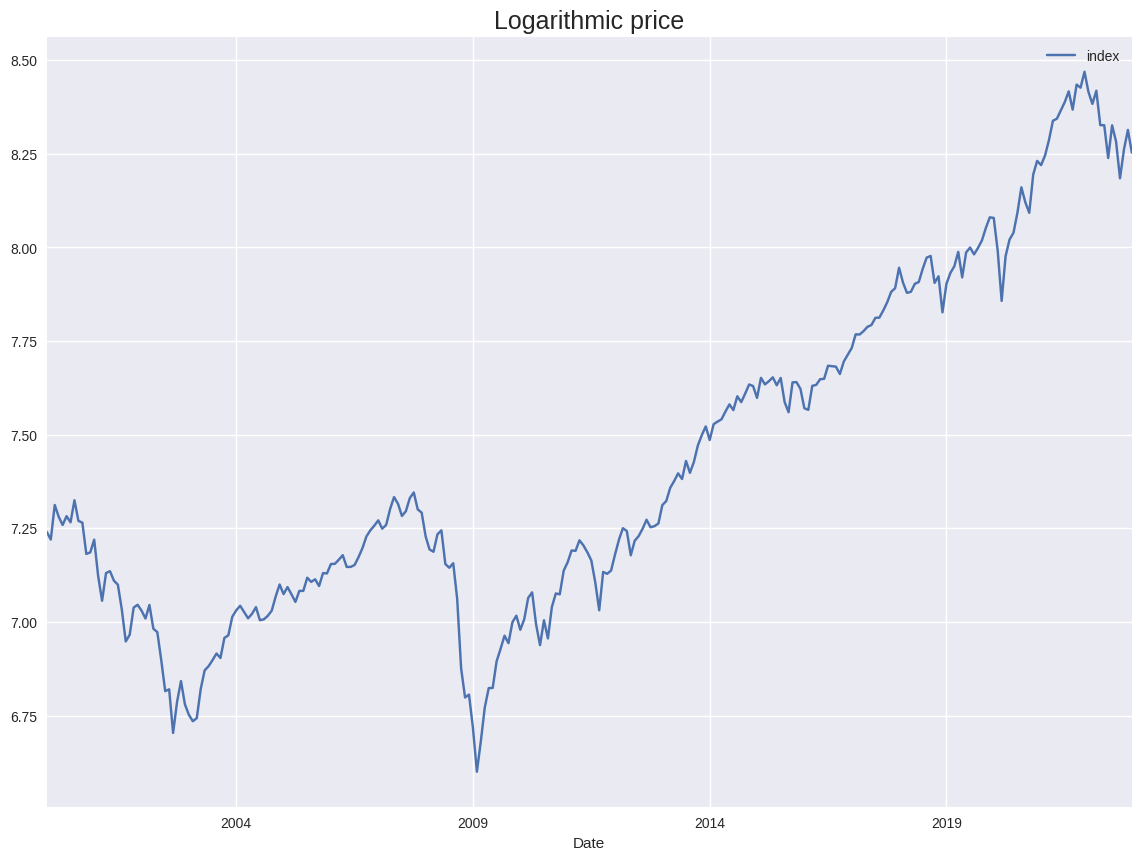

In [23]:
plt.figure()
np.log(data['index']).plot()
plt.legend(loc='best')
plt.title('Logarithmic price',fontsize=18)

ADF Statistic: -16.185564
p-value: 0.000000


<Figure size 1400x1000 with 0 Axes>

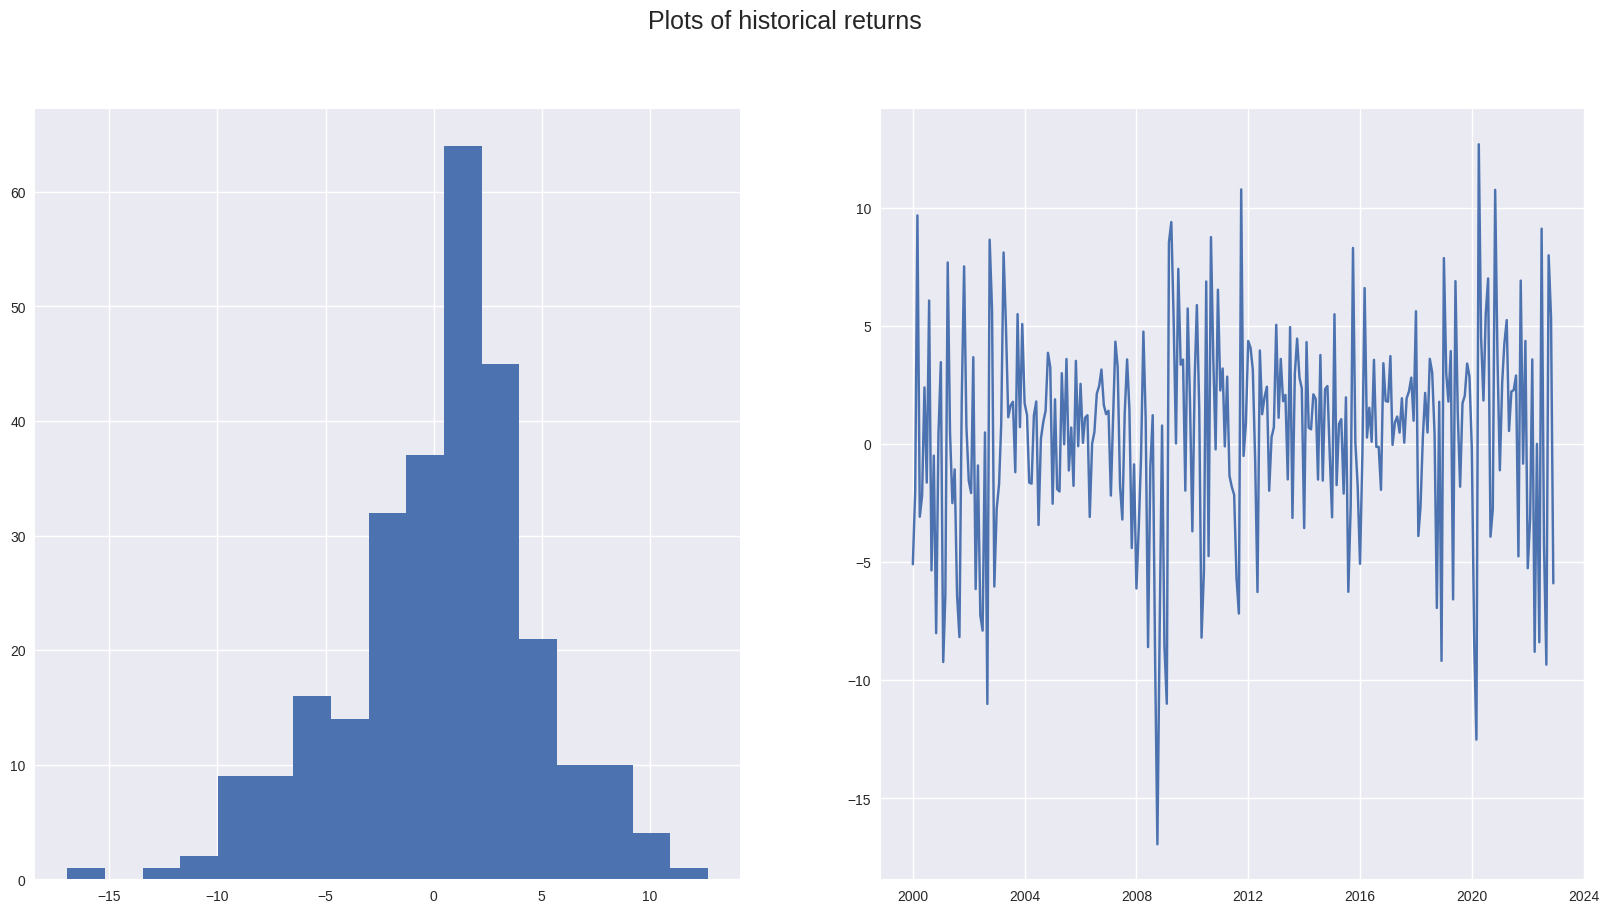

In [24]:
plt.figure()
fig1, axs = plt.subplots(1, 2,figsize=(20, 10))
axs[0].hist(data['index_ret'],bins=round(sqrt(len(data['index_ret']))))
axs[1].plot(data['index_ret'])
fig1.suptitle('Plots of historical returns',fontsize=18)

#stationarity test
adf = adfuller(data['index_ret'].dropna()) #don't use defualt settings, include more outputs
print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])

subindex_ret correlation with market index: 0.9296446249641374
subindex_ret correlation with small-company portfolio index: 0.05526180315505902
subindex_ret correlation with value stocks index: 0.14772001413852937
subindex_ret correlation with momentum factor: 0.2545366534638175
subindex_ret correlation with small-company portfolio index: 0.08959788867969218
subindex_ret correlation with value stocks index: 0.25368414745100226
subindex_ret correlation with momentum factor: 0.03944626883400812


<Figure size 1400x1000 with 0 Axes>

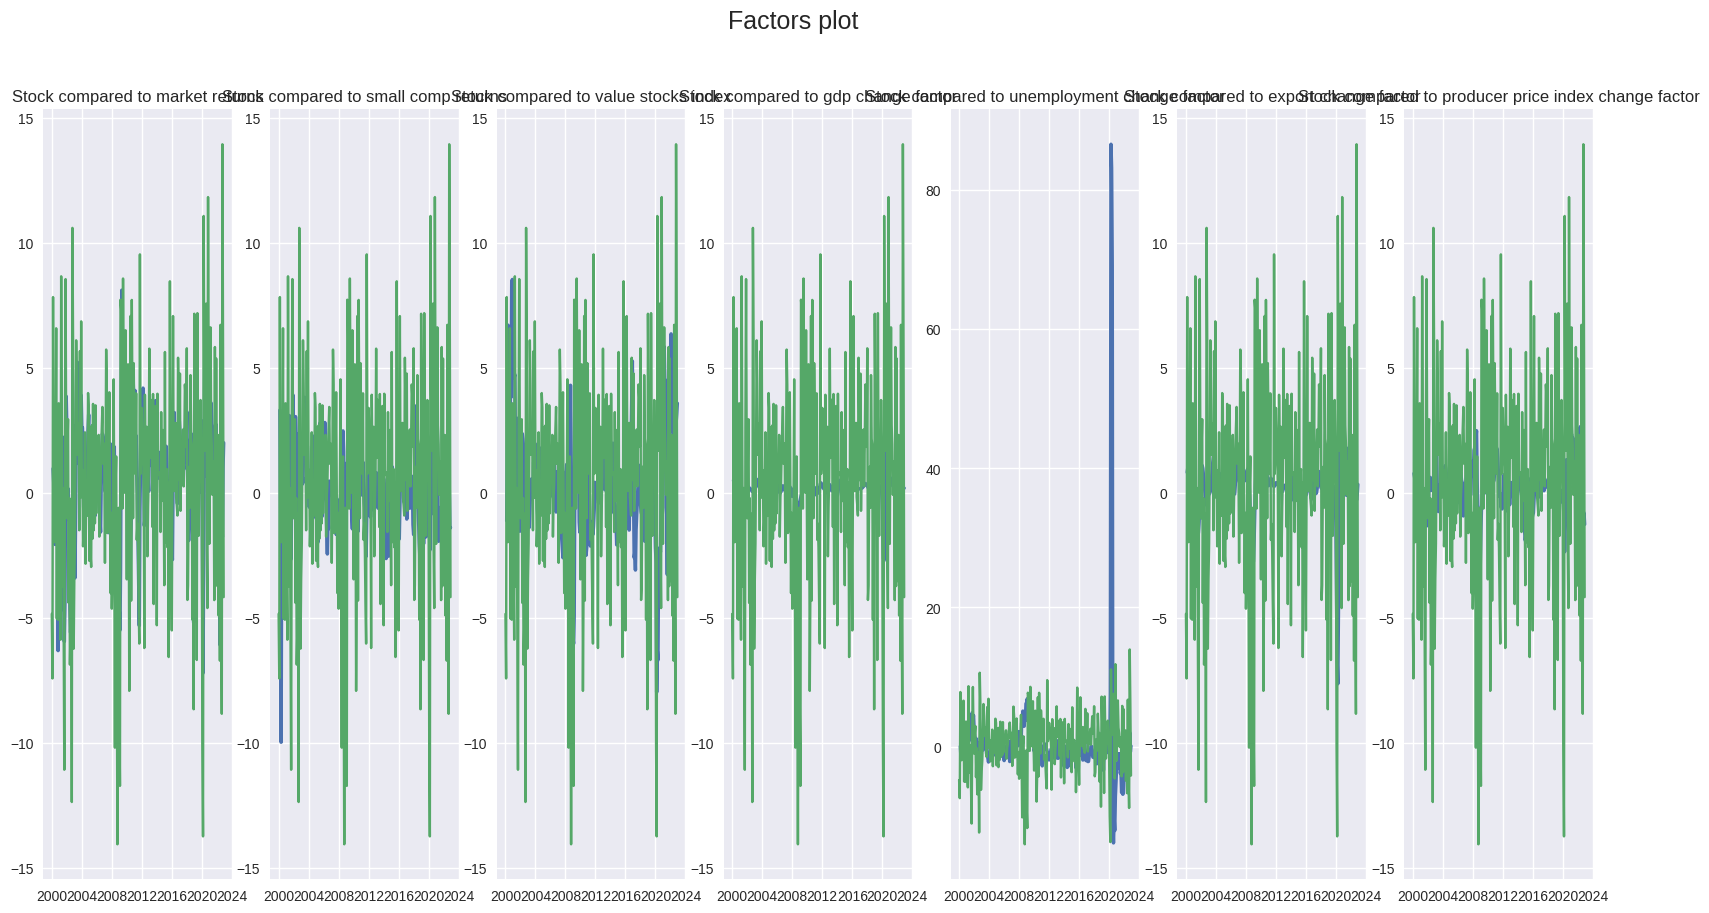

In [25]:
#drop NAs
data = data.dropna()

#set names for the target variable and factors:
stock = 'subindex_ret'
factorsw = ['Mkt-RF', 'SMB', 'HML', 'gdp', 'unemp', 'exp', 'ppi']
factorswo = ['Mkt-RF', 'gdp', 'unemp', 'exp', 'ppi']

#plot fama-french factors:
plt.figure()
fig3, axs = plt.subplots(1, 7,figsize=(20, 10))
axs[0].plot(data['Mkt-RF'].rolling(3).mean(),linewidth=2.5)
axs[0].plot(data[stock])
axs[0].set_title('Stock compared to market returns')
axs[1].plot(data['SMB'].rolling(3).mean(),linewidth=2.5)
axs[1].plot(data[stock])
axs[1].set_title('Stock compared to small comp returns')
axs[2].plot(data['HML'].rolling(3).mean(),linewidth=2.5)
axs[2].plot(data[stock])
axs[2].set_title('Stock compared to value stocks index')
axs[3].plot(data['gdp'].rolling(3).mean(),linewidth=2.5)
axs[3].plot(data[stock])
axs[3].set_title('Stock compared to gdp change factor')
axs[4].plot(data['unemp'].rolling(3).mean(),linewidth=2.5)
axs[4].plot(data[stock])
axs[4].set_title('Stock compared to unemployment change factor')
axs[5].plot(data['exp'].rolling(3).mean(),linewidth=2.5)
axs[5].plot(data[stock])
axs[5].set_title('Stock compared to export change factor')
axs[6].plot(data['ppi'].rolling(3).mean(),linewidth=2.5)
axs[6].plot(data[stock])
axs[6].set_title('Stock compared to producer price index change factor')

fig3.suptitle('Factors plot',fontsize=18)

#calculate correlations
cor = data.corr()

print(f'{stock} correlation with market index:',cor['Mkt-RF'][data.columns.get_loc(stock)])
print(f'{stock} correlation with small-company portfolio index:',cor['SMB'][data.columns.get_loc(stock)])
print(f'{stock} correlation with value stocks index:',cor['HML'][data.columns.get_loc(stock)])
print(f'{stock} correlation with momentum factor:',cor['gdp'][data.columns.get_loc(stock)])
print(f'{stock} correlation with small-company portfolio index:',cor['unemp'][data.columns.get_loc(stock)])
print(f'{stock} correlation with value stocks index:',cor['exp'][data.columns.get_loc(stock)])
print(f'{stock} correlation with momentum factor:',cor['ppi'][data.columns.get_loc(stock)])

In [26]:
#set variables
Y = data[stock] - data['RF'] #substract the risk free rate

X = data[factorswo]

#Build model
from statsmodels.api import OLS

#build model
model = sm.OLS(Y)
result = model.fit()

#examine results
print(result.summary())

#obtain average values:
avr = data.apply(np.mean)

#evaluate expected returns for stock
Int,Mkt,gdp,unemp,exp,ppi = result.params

exp_returns = Mkt*avr['Mkt-RF'] + gdp*avr['gdp'] + unemp*avr['unemp'] + exp*avr['exp'] + ppi*avr['ppi'] #here we drop the intercept, because it represents the excess return over the market

e_rets = exp_returns - data['RF'].mean()

print(f'The expected monthly return for {stock} is:',e_rets/100)
print(f'The expected annual return for {stock} is:',((1 + e_rets/100) ** 12) - 1)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     366.4
Date:                Sat, 25 Nov 2023   Prob (F-statistic):          4.70e-118
Time:                        09:06:12   Log-Likelihood:                -515.09
No. Observations:                 276   AIC:                             1042.
Df Residuals:                     270   BIC:                             1064.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0406      0.106     -0.383      0.7

In [27]:
#set variables
Y = data[stock] - data['RF'] #substract the risk free rate

X = data[factorsw]

#Build model
from statsmodels.api import OLS

#build model
model = sm.OLS(Y)
result = model.fit()

#examine results
print(result.summary())

#obtain average values:
avr = data.apply(np.mean)

#evaluate expected returns for stock
Int,Mkt,SMB,HML,gdp,unemp,exp,ppi = result.params

exp_returns = Mkt*avr['Mkt-RF'] + SMB*avr['SMB'] + HML*avr['HML'] + gdp*avr['gdp'] + unemp*avr['unemp'] + exp*avr['exp'] + ppi*avr['ppi'] #here we drop the intercept, because it represents the excess return over the market

e_rets = exp_returns - data['RF'].mean()

print(f'The expected monthly return for {stock} is:',e_rets/100)
print(f'The expected annual return for {stock} is:',((1 + e_rets/100) ** 12) - 1)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     467.9
Date:                Sat, 25 Nov 2023   Prob (F-statistic):          2.98e-146
Time:                        09:06:12   Log-Likelihood:                -441.99
No. Observations:                 276   AIC:                             900.0
Df Residuals:                     268   BIC:                             929.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0527      0.082     -0.645      0.5